In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
import os
import numpy as np
from sklearn.metrics import average_precision_score

In [18]:
def cal_iou(predict, ground_truth):
    """
        predict: [x1, y1, x2, y2]
        ground_truth: [x1, y1, x2, y2]

        return: iou
    """
    predict_area = (predict[2] - predict[0]) * (predict[3] - predict[1])
    ground_truth_area = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])

    # get the each coordinate of intersection rectangle
    left = max(predict[0], ground_truth[0])
    right = min(predict[2], ground_truth[2])
    top = max(predict[1], ground_truth[1])
    bottom = min(predict[3], ground_truth[3])

    if left >= right or top >= bottom:
        return 0.0

    intersection_area = (right - left) * (bottom - top)
    union_area = predict_area + ground_truth_area - intersection_area
    return intersection_area / union_area

def cal_mAP_at_th(ground_truth, predict, iou_threshold=0.5):
    """
        ground_truth: list of ground truth
        predict: list of predict
        iou_threshold: iou threshold

        return: mAP
    """
    aps = []
    for i in range(len(predict)):
        aps.append(average_precision_score(ground_truth[i], predict[i]))
    return np.mean(aps)

def xywh_to_xyxy(yolo_box):
    """
        yolo_box: [x, y, w, h]

        return: [x1, y1, x2, y2]
    """
    x1 = yolo_box[0] - yolo_box[2] / 2
    y1 = yolo_box[1] - yolo_box[3] / 2
    x2 = yolo_box[0] + yolo_box[2] / 2
    y2 = yolo_box[1] + yolo_box[3] / 2
    return [x1, y1, x2, y2]

def read_labels(label_paths):
    """
        label_paths: list of label path

        return: graph_gt, table_gt
    """
    graph_gt = [] # 0
    table_gt = [] # 1
    
    for label_path in label_paths:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.split()
                xywh = [float(line[1]), float(line[2]), float(line[3]), float(line[4])]
                if line[0] == '0':
                    graph_gt.append(xywh_to_xyxy(xywh))
                elif line[0] == '1':
                    table_gt.append(xywh_to_xyxy(xywh))
    
    return graph_gt, table_gt

def get_xyxyn(results):
    """
        results: list of result

        return: graph_pred, table_pred
    """
    graph_pred = [] # 0
    table_pred = [] # 1
    
    for result in results:
        cls = result.boxes.cls.cpu().numpy()
        xywh = result.boxes.xywhn.cpu().numpy()
        for i, c in enumerate(cls):
            bbox = xywh_to_xyxy(xywh[i])
            if c == 0:
                graph_pred.append(bbox)
            elif c == 1:
                table_pred.append(bbox)
    
    return graph_pred, table_pred

def get_mean_iou(ground_truth, predict):
    """
        ground_truth: list of ground truth
        predict: list of predict

        return: mean_iou
    """
    iou_graphs = []
    for i in range(len(predict)):
        iou_graphs.append(cal_iou(predict[i], ground_truth[i]))
    return np.mean(iou_graphs)

def get_mAP(ground_truth, predict):
    """
        ground_truth: list of ground truth
        predict: list of predict

        return: mAP
    """
    weight = [0.5, 0.55, 0.6 ,0.95]
    mAPs = []
    for i in range(len(weight)):
        for j in range(len(predict)):
            mAPs.append(cal_mAP_at_th(ground_truth[j], predict[j], weight[i]))
    return np.mean(mAPs)
    

In [8]:
yolov5_df = pd.read_csv('runs/detect/yolov5/results.csv')
yolov8_df = pd.read_csv('runs/detect/yolov8/results.csv')

In [19]:
yolov8_df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.52990,3.41150,1.50520,0.00722,1.00000,0.70934,0.52431,0.49542,2.95490,0.89980,0.000133,0.000133,0.000133
1,1,0.67344,2.22030,0.98880,0.18545,1.00000,0.99500,0.93221,0.31897,2.20030,0.75578,0.000281,0.000281,0.000281
2,2,0.45675,1.18210,0.85574,1.00000,0.29642,0.79487,0.73826,0.41169,2.64660,0.86923,0.000425,0.000425,0.000425
3,3,0.42016,0.84546,0.83925,1.00000,0.44489,0.59136,0.55550,0.48501,2.74230,0.97364,0.000566,0.000566,0.000566
4,4,0.45400,0.81549,0.84928,0.99789,1.00000,0.99500,0.92091,0.42289,0.95986,0.77306,0.000704,0.000704,0.000704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.20322,0.22645,0.80749,0.99901,1.00000,0.99500,0.99103,0.19340,0.15747,0.78916,0.000116,0.000116,0.000116
96,96,0.19839,0.22316,0.81736,0.99902,1.00000,0.99500,0.99103,0.18813,0.15489,0.78783,0.000099,0.000099,0.000099
97,97,0.18267,0.20614,0.80505,0.99906,1.00000,0.99500,0.99101,0.18073,0.15124,0.78712,0.000083,0.000083,0.000083
98,98,0.19983,0.22477,0.80585,0.99907,1.00000,0.99500,0.99095,0.17709,0.15096,0.78669,0.000066,0.000066,0.000066


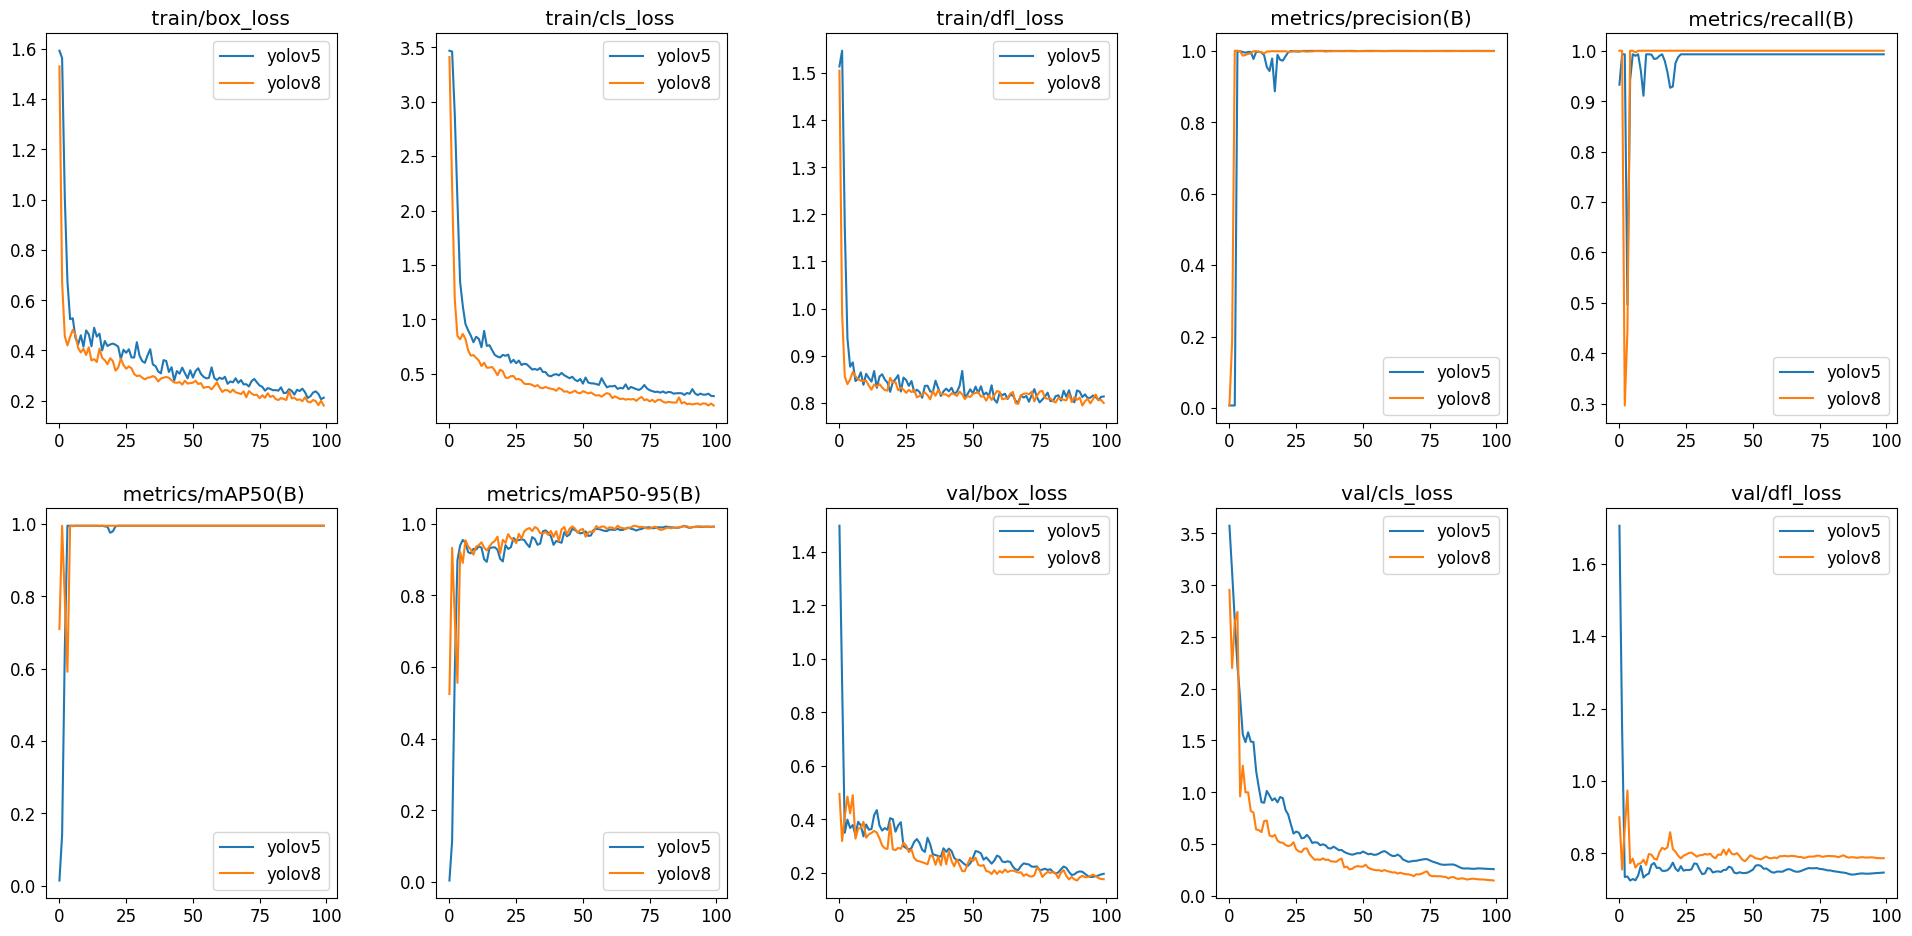

In [9]:
metrics = yolov5_df.columns.values[1:-3] # not include 'epoch' and lr column
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.tight_layout(pad=3.0)
plt.rcParams.update({'font.size': 12})

for i, metric in enumerate(metrics):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yolov5_df.iloc[:, i+1])
    axs[row, col].plot(yolov8_df.iloc[:, i+1])
    axs[row, col].set_title(metric)
    axs[row, col].legend(['yolov5', 'yolov8'])
plt.show()

In [10]:
model = YOLO('runs\\detect\\yolov5\\weights\\best.pt')
# model.val()
# image path
test_image_dir = Path('data/images/test')
test_image_path = [str(file) for file in test_image_dir.glob('*')]
train_image_dir = Path('data/images/train')
train_image_path = [str(file) for file in train_image_dir.glob('*')]
# label path
test_label_dir = Path('data/labels/test')
test_label_path = [str(file) for file in test_label_dir.glob('*')]
train_label_dir = Path('data/labels/train')
train_label_path = [str(file) for file in train_label_dir.glob('*')]

In [14]:
model.val()

Ultralytics YOLOv8.0.118  Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
val: Scanning C:\Users\earth\OneDrive\Desktop\Audiogram\src\data_extracter\graph_table\data\labels\train.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]
                   all        140        282          1      0.993      0.995      0.993
             ear_graph        140        141          1      0.993      0.995      0.995
             pta_table        140        141      0.999      0.993      0.995       0.99
Speed: 1.0ms preprocess, 4.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\val9


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x0000017E4A780220>
fitness: 0.9929595327063617
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([      0.995,     0.99047])
names: {0: 'ear_graph', 1: 'pta_table'}
plot: True
results_dict: {'metrics/precision(B)': 0.9995447015392878, 'metrics/recall(B)': 0.9929078014184397, 'metrics/mAP50(B)': 0.995, 'metrics/mAP50-95(B)': 0.9927328141181796, 'fitness': 0.9929595327063617}
save_dir: WindowsPath('runs/detect/val9')
speed: {'preprocess': 1.0128685406276157, 'inference': 4.581277711050851, 'loss': 0.0, 'postprocess': 3.185091699872698}

In [12]:
test_results = model(test_image_path)
test_graph_gt, test_table_gt = read_labels(test_label_path)
test_graph_predict, test_table_predict = get_xyxyn(test_results)
test_graph_iou = get_mean_iou(test_graph_gt, test_graph_predict)
test_table_iou = get_mean_iou(test_table_gt, test_table_predict)
print('test_graph_iou: ', test_graph_iou)
print('test_table_iou: ', test_table_iou)

0: 640x640 1 ear_graph, 1 pta_table, 1: 640x640 1 ear_graph, 1 pta_table, 2: 640x640 1 ear_graph, 1 pta_table, 3: 640x640 1 ear_graph, 1 pta_table, 4: 640x640 1 ear_graph, 1 pta_table, 5: 640x640 1 ear_graph, 1 pta_table, 6: 640x640 1 ear_graph, 1 pta_table, 7: 640x640 1 ear_graph, 1 pta_table, 8: 640x640 1 ear_graph, 1 pta_table, 9: 640x640 1 ear_graph, 1 pta_table, 10: 640x640 1 ear_graph, 1 pta_table, 11: 640x640 1 ear_graph, 1 pta_table, 12: 640x640 1 ear_graph, 1 pta_table, 13: 640x640 1 ear_graph, 1 pta_table, 14: 640x640 1 ear_graph, 1 pta_table, 15: 640x640 1 ear_graph, 1 pta_table, 16: 640x640 1 ear_graph, 1 pta_table, 17: 640x640 1 ear_graph, 1 pta_table, 18: 640x640 1 ear_graph, 1 pta_table, 19: 640x640 1 ear_graph, 1 pta_table, 20: 640x640 1 ear_graph, 1 pta_table, 21: 640x640 1 ear_graph, 1 pta_table, 22: 640x640 1 ear_graph, 1 pta_table, 23: 640x640 1 ear_graph, 1 pta_table, 24: 640x640 1 ear_graph, 1 pta_table, 25: 640x640 1 ear_graph, 1 pta_table, 26: 640x640 1 ear_grap

test_graph_iou:  0.9807062575540296
test_table_iou:  0.9717035646563161


In [13]:
train_results = model(train_image_path)
train_graph_gt, train_table_gt = read_labels(train_label_path)
train_graph_predict, train_table_predict = get_xyxyn(train_results)
train_graph_iou = get_mean_iou(train_graph_gt, train_graph_predict)
train_table_iou = get_mean_iou(train_table_gt, train_table_predict)
print('train_graph_iou: ', train_graph_iou)
print('train_table_iou: ', train_table_iou)


0: 640x640 1 ear_graph, 1 pta_table, 1: 640x640 1 ear_graph, 1 pta_table, 2: 640x640 1 ear_graph, 1 pta_table, 3: 640x640 1 ear_graph, 1 pta_table, 4: 640x640 1 ear_graph, 1 pta_table, 5: 640x640 1 ear_graph, 1 pta_table, 6: 640x640 1 ear_graph, 1 pta_table, 7: 640x640 1 ear_graph, 1 pta_table, 8: 640x640 1 ear_graph, 1 pta_table, 9: 640x640 1 ear_graph, 1 pta_table, 10: 640x640 1 ear_graph, 1 pta_table, 11: 640x640 1 ear_graph, 1 pta_table, 12: 640x640 1 ear_graph, 1 pta_table, 13: 640x640 1 ear_graph, 1 pta_table, 14: 640x640 1 ear_graph, 1 pta_table, 15: 640x640 1 ear_graph, 1 pta_table, 16: 640x640 1 ear_graph, 1 pta_table, 17: 640x640 1 ear_graph, 1 pta_table, 18: 640x640 1 ear_graph, 1 pta_table, 19: 640x640 1 ear_graph, 1 pta_table, 20: 640x640 1 ear_graph, 1 pta_table, 21: 640x640 1 ear_graph, 1 pta_table, 22: 640x640 1 ear_graph, 1 pta_table, 23: 640x640 1 ear_graph, 1 pta_table, 24: 640x640 1 ear_graph, 1 pta_table, 25: 640x640 1 ear_graph, 1 pta_table, 26: 640x640 1 ear_gra

train_graph_iou:  0.934351003868203
train_table_iou:  0.9136885031392735
